# План работы

1. Загрузка и подготовка данных.
2. Обучение моделей. 
3. Выводы.

## Подготовка

<div style="border:solid blue 2px; padding: 20px">

Импортируем библиотеки
</div>

In [1]:
#!pip install catboost

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import string
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm

<div style="border:solid blue 2px; padding: 20px">

Откроем и изучим файл
    
    
</div>

In [3]:
# чтение файла с данными и сохранение в data_users
# метод try-except поможет загрузить данные локально или глобально
try:
    df = pd.read_csv('C:/Users/toxic_comments.csv')  # Локальный путь
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')  # Серверный путь

<div style="border:solid blue 2px; padding: 20px">
    
`head()` выводим на экран первые пять строк таблицы:
    </div>

In [4]:
# получение первых 5 строк таблицы
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<div style="border:solid blue 2px; padding: 20px">
    
`info()` получим общую информацию о таблице:
    </div>

In [5]:
# получение общей информации о данных в таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


<div style="border:solid blue 2px; padding: 20px">
    
 
Методом `describe()` получим описание данных 
    
    
</div> 

In [6]:
# описание данных
df.describe()

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<div style="border:solid blue 2px; padding: 20px">
 
    
Методом `value_counts()` посмотрим как часто в целевом признаке встречается класс `0` и `1`.
    
</div>

0    0.898321
1    0.101679
Name: toxic, dtype: float64


<AxesSubplot:>

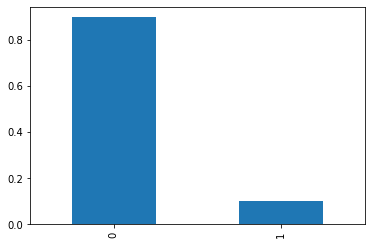

In [7]:
# подсчет значений
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

<div style="border:solid blue 2px; padding: 20px">
 
    
Около `10%` значений по факту токсичных комментариев. 
    
Баланс классов `0/1` соостветсвует соотношению `9/1`    

    
    
</div>

<div style="border:solid blue 2px; padding: 20px">
 
    
Обучим модель без учёта дисбаланса
    
    

    
    
</div>

<div style="border:solid blue 2px; padding: 20px">
    
Посчитаем сколько строк являются дубликатами.
    
    
</div>

In [8]:
# подсчет явных дубликатов
print('Всего строк дубликатов: ', df.duplicated().sum())

Всего строк дубликатов:  0


<div style="border:solid blue 2px; padding: 20px">
    
**Основные метасимволы**
    
`[]` - используются для указания набора или диапазона символов
    
`\` - указывает на начало последовательности или экранирует служебные символы
    
`.` -  выбирает любой символ, кроме новой строки `\n`
    
`^` -  проверяет, начинается ли строка с определенного символа / слова / набора символов
    
`^` - в наборе c `[]` - проверяет, отсутствуют ли в строке определенные символы
    
`$` - проверяет, заканчивается ли строка в соответствии с шаблоном

`*` - ноль или больше совпадений с шаблоном

`+` - одно или больше совпадений с шаблоном

`?` - ноль или одно совпадение с шаблоном. Кроме того, нейтрализует «жадность» выражений, которые используют `.`, `*`, `+` для выбора любых символов

`{}`– точное число совпадений

`|` - любой из двух вариантов

`<>` - создают именованную группу

**Основные последовательности**

`\W` - возвращает совпадение по каждому «несловесному» символу

`\w` - проверяет, есть ли в строке «словесные» символы – знак нижнего подчеркивания, цифры и буквы  - `[a-zA-Z0-9_]`

`\S` - возвращает совпадение, если в строке есть любые символы, кроме пробелов

`\s` - проверяет наличие пробелов в строке

`\n` - соответствует символу новой строки

`\d` - проверяет, что в строке есть цифры от 0 до 9

    
</div> 

<div style="border:solid blue 2px; padding: 20px">
    

Создадим функцию с именем `clear_text()` c параметрами `text`, в теле функции    
    
регулярными выражениями очистим текст от лишних символов
    
Методом `lower()` преобразуем все символы верхнего регистра в строке в символы нижнего
    
Применим шаблоны `pattern` для составления регуляного выражения из 
    
онлайн-конструктора регулярных выражений [regex101.com/](https://regex101.com/)
    
`\[.*?\]` - соответствует как можно меньшему количеству символов
    
`\\W` - соотв чему угодно, кроме буквы, цифры или символа подчеркивания - `[^a-zA-Z0-9_]`
    
`https?://\S+|www\.\S+` - cоответствует либо тому, что находится перед `|`, либо тому, 
    
что находится после него - в данном случае `https?://\S+` или `www\.\S+`
    
`<.*?>+` - использование будет соответствовать только `<a>`
    
Cодержание модуля `escape()` `string.punctuation` - это предварительно инициализированная 
    
строка, используемая как строковая константа даст все наборы знаков препинания
    
    
!"#$%&'()*+, -./:;<=>?@[ \ ]^_`{|}~

`\n` - использование будет соответствовать оответствует символу новой строки

`\w*\d\w*` - использование будет соответствовать `[a-zA-Z0-9_]*[0-9][a-zA-Z0-9_]*`
    
</div> 

In [9]:
def clear_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\\W',' ',text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [10]:
# применение функции
df['text'] = df['text'].apply(clear_text)

<div style="border:solid blue 2px; padding: 20px">

### Вывод


    
    
</div>

<div style="border:solid blue 2px; padding: 20px">
    
**Оценка полученных данных**

Наблюдения, представленные в таблице описываются категориальными значениями.
    
Данные можно исследовать для дальнейшего анализа.
    
    
**Таблица `toxic_comments` (данные с разметкой о токсичности)**:
    
`text` — текст коментария
    
`toxics` — целевой признак — (коментарии «позитивные» — 0, «негативные» — 1)
    
Таблица содержит в среднем `0.101679` коментариев для модерации: оценили баланс классов
    
Проверили на наличие явных дубликатов
    
От лишних символов текст очистили регулярными выражениями
    
</div>

## Обучение

<div style="border:solid blue 2px; padding: 20px">
    
 
Исследуем качество на модели — CatBoostClassifier().

    
    
</div> 

<div style="border:solid blue 2px; padding: 20px">
    
 
`train_test_split()` разделим исходные данные на обучающую, валидационную и тестовую выборки
    
    
</div> 

In [11]:
# получение обучающей выборки
df_train, df_part = train_test_split(df, test_size=0.4, random_state=42)
print('Объектов обучающей выборки', len(df_train) / len(df))

Объектов обучающей выборки 0.5999962399182809


In [12]:
# получение валидационной и тестовой выборки
df_valid, df_test = train_test_split(df_part, test_size=0.5, random_state=42)
print('Объектов валидационной выборки', len(df_valid) / len(df))
print('Объектов тестовой выборки', len(df_test) / len(df))

Объектов валидационной выборки 0.19999874663942696
Объектов тестовой выборки 0.20000501344229216


<div style="border:solid blue 2px; padding: 20px">
    
 
Признаки сохраним в отдельных переменных 
    
    
- X - `features`
    
    
- y - `target` - целевой признак
    
    
</div> 

In [13]:
# сохранение признаков в отдельных переменных
X = ['text']
y = ['toxic']
text_features = ['text']

In [14]:
params = {'eval_metric':'AUC',
          'text_features':text_features,
          'random_state': 42,
          'learning_rate':0.1,
          'verbose':100}

In [15]:
cbc = CatBoostClassifier(**params)

In [16]:
cbc.fit(df_train[X], df_train[y], eval_set=(df_valid[X], df_valid[y]))

0:	test: 0.8361802	best: 0.8361802 (0)	total: 739ms	remaining: 12m 17s
100:	test: 0.9606429	best: 0.9606554 (99)	total: 1m 13s	remaining: 10m 57s
200:	test: 0.9643188	best: 0.9643188 (200)	total: 2m 29s	remaining: 9m 55s
300:	test: 0.9659732	best: 0.9659732 (300)	total: 3m 50s	remaining: 8m 56s
400:	test: 0.9670393	best: 0.9670393 (400)	total: 5m 4s	remaining: 7m 34s
500:	test: 0.9674967	best: 0.9675134 (496)	total: 6m 22s	remaining: 6m 20s
600:	test: 0.9678071	best: 0.9678071 (600)	total: 7m 35s	remaining: 5m 2s
700:	test: 0.9679079	best: 0.9679210 (696)	total: 8m 50s	remaining: 3m 46s
800:	test: 0.9679335	best: 0.9680189 (762)	total: 10m 14s	remaining: 2m 32s
900:	test: 0.9678770	best: 0.9680189 (762)	total: 11m 25s	remaining: 1m 15s
999:	test: 0.9677742	best: 0.9680189 (762)	total: 12m 39s	remaining: 0us

bestTest = 0.9680188791
bestIteration = 762

Shrink model to first 763 iterations.


AUC-ROC CatBoostClassifier 0.9680188791026076


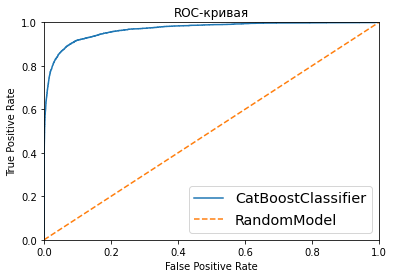

In [17]:
probabilities_one_valid = cbc.predict_proba(df_valid[X])[:, 1]
fpr, tpr, thresholds = roc_curve(df_valid[y], probabilities_one_valid)
auc_roc = roc_auc_score(df_valid[y], probabilities_one_valid)
print('AUC-ROC CatBoostClassifier',auc_roc)
plt.plot(fpr, tpr, label='CatBoostClassifier')
plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right', fontsize='x-large')
plt.title("ROC-кривая")
plt.show()

<div style="border:solid blue 2px; padding: 20px">
    
Метрика `AUC-ROC` модели `0.968` на валидационной выборке


    
</div> 

<div style="border:solid blue 2px; padding: 20px">
    
Подберём оптимальный порог

    
</div> 

In [18]:
result = []
for threshold in tqdm(thresholds):
    predicted_valid = (probabilities_one_valid > threshold) * 1
    result.append((threshold, f1_score(df_valid[y],predicted_valid)))

  0%|          | 0/2547 [00:00<?, ?it/s]

In [19]:
data_f1 = pd.DataFrame(result,columns=['threshold','f1'])

In [20]:
data_f1[data_f1['f1'] == data_f1['f1'].max()]

,threshold,f1
678,0.382562,0.797064


<div style="border:solid blue 2px; padding: 20px">
    
 
Исследуем модель на тестовой выборке — с учётом порога `0.418`.
    
    
</div> 

In [21]:
# значением метрики качества AUC-ROC
print('метрика AUC-ROC на тестовой выборке', roc_auc_score(df_test[y], cbc.predict_proba(df_test[X])[:, 1]))

метрика AUC-ROC на тестовой выборке 0.9714754508265581


In [24]:
# предсказания на тестовой выборке
predicted_test = (cbc.predict_proba(df_test[X])[:, 1] > 0.382562) * 1

In [25]:
# значением метрики качества F1
print('метрика F1 на тестовой выборке', f1_score(df_test[y],predicted_test))

метрика F1 на тестовой выборке 0.7858490566037736


## Выводы

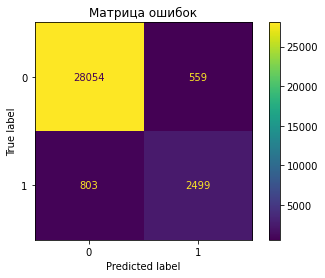

In [47]:
cm = confusion_matrix(df_test[y], predicted_test, labels=cbc.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cbc.classes_)
display.plot()
plt.title('Матрица ошибок')
plt.show()

<div style="border:solid blue 2px; padding: 20px">
    
Метрика `AUC-ROC` на тестовой выборке для полученной модели составляет `0.971`
    
Исходя из идеального показателя `AUC-ROC = 1`, можно оценить модель как `хорошую`.
    
Метрика `F1` на тестовой выборке для полученной модели составляет `0.78`
    
Следовательно с такими показателями метрик `f1-мера` и `AUC-ROC` модель будет выполнять работу.
    
По матрице ошибок можно рекомендовать полученную модель для поиска токсичных комментариев.
    
    
</div> 